## Семинар 1 "Полносвязные нейронные сети"

ФИО: Пронин Сергей Юрьевич

В этом задании вам предстоит реализовать проход "вперед" для полносвязной нейронную сети. В дальнейшем мы реализуем процедуру обучения и научим сеть распознавать рукописные цифры.

На первой лекции мы познакомились с тем, что такое нейронные сети и изучили три слоя — линейный, сигмоида и SoftMax. Из этих слоев можно составлять глубокие архитектуры и обучать их при помощи градиентного спуска. Чтобы конструировать сложные архитектуры, можно реализовать каждый тип слоя как отдельный "кирпичик" и затем собирать полную архитектуру как конструктор. Это мы и попробуем сделать на первом и втором семинарах.

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции: forward, которая будет применять функцию, реализуемую слоем, к входной матрице и backward, которая будет вычислять градиенты и step, которая будет обновлять веса. Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов, а d — размерность каждого объекта.

<img src=backprop.pdf width=400>

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

In [360]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import expit as sigmoid
%matplotlib inline

### Часть 1: Линейный слой


In [363]:
class Linear:
    def __init__(self, input_size, output_size, use_bias=True, init_loc=0.0, init_scale=0.1):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''        
        self._use_bias = use_bias
        self._input_size = input_size + 1 if self._use_bias else input_size
        self._output_size = output_size
        self._weights = np.random.normal(loc=init_loc, scale=init_scale, size=(self._input_size, self._output_size))
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self._X = np.c_[X, np.ones(X.shape[0])] if self._use_bias else X.copy()
        return np.dot(self._X, self._weights)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        self._dLdw = np.dot(self._X.T, dLdy)
        return np.dot(dLdy, self._weights[:-1].T if self._use_bias else self._weights.T)
    
    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - l*dLdw
        '''
        self._weights -= learning_rate * self._dLdw

### Часть 2: Сигмоида

In [364]:
class Sigmoid:
    def __init__(self):
        pass
    
    def _sigmoid(self, X):
        return 1. / (1. + np.exp(-X))
    
    def _sigmoid_derivative(self):
        return self._sigmoid_val * (1.0 - self._sigmoid_val)
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self._X = X.copy()
        self._sigmoid_val = sigmoid(X)
        return self._sigmoid_val
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return dLdy * self._sigmoid_derivative()
    
    def step(self, learning_rate):
        pass

### Часть 3: Функция потерь

Как мы увидели на семинаре, вычисление производной для связки SoftMax + Negative log-likelihood проще чем для этих двух слоев по отдельности. Поэтому мы реализуем их как один класс. Важное замечание: на проходе "вперед" важно воспользоваться трюком <a href="https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/">log-sum-exp</a>, чтобы не столкнуться с численными неустойчивостями.

In [365]:
class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        y is np.array of size (N), contains correct labels
        '''
        self._y_mat = pd.get_dummies(y).values.astype(bool)
        a = np.max(X)
        self._p = np.exp(X - a)
        self._p /= self._p.sum(axis=1, keepdims=True)
        return np.sum(-np.log(self._p[self._y_mat])) - a
    
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        dLdx = self._p.copy()
        dLdx[self._y_mat] -= 1.0
        return dLdx        

### Часть 4, нейронная сеть

Теперь, когда у нас есть "кирпичики", мы можем написать класс, который будет собирать всю сеть вместе 

In [366]:
# assume that modules is a list of layers or other neural networks
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self._modules = modules
    
    def forward(self, X):
        self._X = X.copy()
        for module in self._modules:
            self._X = module.forward(self._X)
        return self._X
            
    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function or straightforward layer or neural network
        '''
        tmp = dLdy.copy()
        for module in reversed(self._modules):
            tmp = module.backward(tmp)
        return tmp
    
    def step(self, learning_rate):
        for module in self._modules:
            module.step(learning_rate)

In [367]:
class NeuralNetworkFitter:
    def __init__(self, neural_network, loss_func, track_loss=True, num_epoch=500, learning_rate=0.01):
        self._neural_network = neural_network
        self._loss_func = loss_func
        self._track_loss = track_loss
        if track_loss:
            self._losses = []
        else:
            self._losses = None
        self._num_epoch = num_epoch
        self._learning_rate = learning_rate
    
    def fit(self, X, y):
        for epoch in xrange(self._num_epoch):
            tmp = self._neural_network.forward(X)
            loss = self._loss_func.forward(tmp, y)
            if self._track_loss:
                self._losses.append(loss)
            tmp = self._loss_func.backward()
            self._neural_network.backward(tmp)
            self._neural_network.step(self._learning_rate)
        return self

### Часть 5, обучение на простых данных

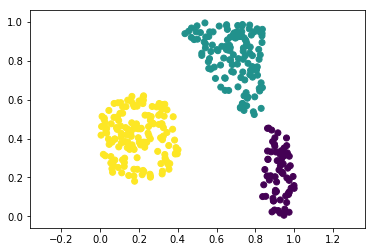

In [377]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Обучите архитектуру вида 2 -> 10 -> 10 -> 3:
* Linear(2, 10)
* Sigmoid()
* Linear(10, 10)
* Sigmoid()
* Linear(10, 3)

В качестве функции потерь используйте NLLLoss.
1. Создайте сеть, в цикле запускайте forward, backward, step (используйте learning rate 0.01). 
2. Нарисуйте график сходимости (изменение NLL со временем).
3. Нарисуйте разделяющую поверхность

Отличная визуализация: http://playground.tensorflow.org/

In [381]:
modules = [Linear(X.shape[1], 10, use_bias=True),
           Sigmoid(),
           Linear(10, 10, use_bias=True),
           Sigmoid(),
           Linear(10, len(np.unique(y)), use_bias=True)]
nn = NeuralNetwork(modules)
cfg = NeuralNetworkFitter(nn, loss_func=NLLLoss(), num_epoch=5000, learning_rate=0.01)
cfg.fit(X, y)

<__main__.NeuralNetworkFitter instance at 0x000000002258B348>

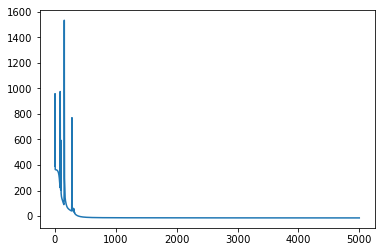

In [382]:
plt.plot(xrange(cfg._num_epoch),cfg._losses)

(-0.055625803913818925,
 1.0603694606862042,
 -0.060969912577174698,
 1.0625850436988611)

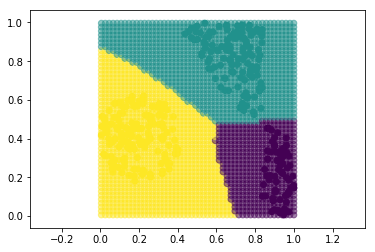

In [383]:
color_points = []
colors = []

for i in np.linspace(X[:, 0].min(), X[:, 0].max(), 50):
    for j in np.linspace(X[:, 1].min(), X[:, 1].max(), 50):
                color_points.append([i, j])
                colors.append(np.argmax(cfg._neural_network.forward(np.array([[i, j]])), axis=1)[0])
color_points = np.array(color_points)
plt.scatter(color_points[:,0], color_points[:,1], c=colors, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')